In [1]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------

import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_harpsn
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.planet import Planet
c = 2.998e5
%load_ext autoreload
%autoreload 2

## Read dataset of `e2ds` files (HARPS-N)
The function reads a set of `M` frames with `N` orders each, with flux values for each wavelength channel `C`
and returns a reshaped `datacube` with shape `(N,M,C)`

In [2]:
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/e2ds/night1/'
files = sorted(glob.glob(data_dir+'*.fits')) # select files

dc = read_harpsn(files, 'e2ds')

# Note: this function outputs VACUUM wavelengths and 
# applies the barycentric correction (i.e. data in stellar frame)

### Load template and planet object

In [3]:
template_path = 'data/wasp189_fe_4000k.fits'
with fits.open(template_path) as hdul:
    hdul.info()
    twave = hdul[0].data
    tflux = hdul[1].data
# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

planet = Planet('wasp189')
planet.BERV = dc.BERV
planet.MJD = dc.MJD

Filename: data/wasp189_fe_4000k.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (72646,)   float64   
  1                1 ImageHDU         6   (72646,)   float64   


### Planet's radial velocity over time
The planet is at mid-eclipse at phase = 0.50.

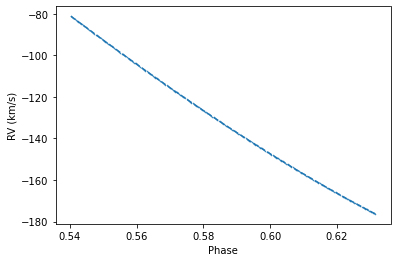

In [4]:
plt.plot(planet.phase, planet.RV,'--o', ms=0.5)
plt.xlabel('Phase')
plt.ylabel('RV (km/s)')
plt.show()

### Advanced reduction routine
We inject an artificial planet signal at the expected RV to assess how the reduction routine affects the planet signal. 
The injection is performed after continuum removal. Very strong injections will alter the noise pattern, hence producing spurious signals.

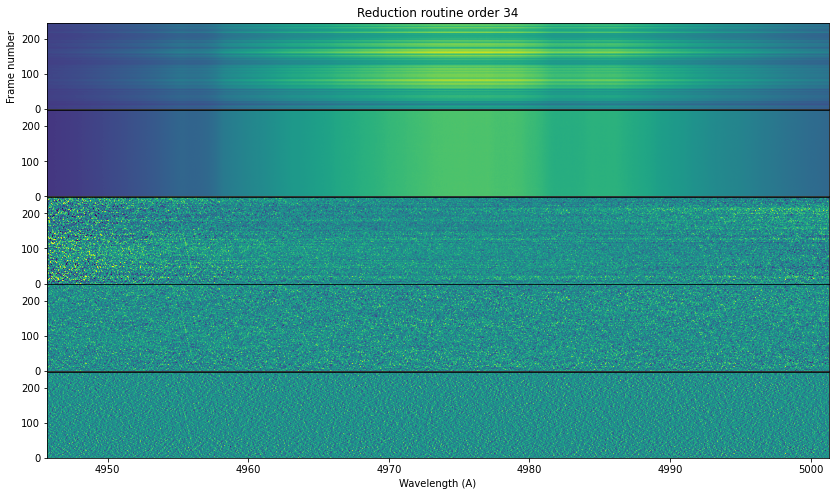

In [5]:
fig, ax = plt.subplots(5,figsize=(14,8))
plt.subplots_adjust(hspace=0.01)

# First select an order
order = 34
dco = dc.order(order)
dco.wlt = np.median(dco.wlt, axis=0)

dco.imshow(ax=ax[0])

# Remove continuum
dco.normalise()

# Inject signal
factor = 50. # strenght of the injection (1 is the expected planetary signal, set to 0 to ignore this step)
if factor > 0:
    dco.inject_signal(planet, template, factor=factor)

# dco.sigma_clip(debug=True)
dco.imshow(ax=ax[1])

# Airmass detrend
dco.airmass_detrend()
dco.imshow(ax=ax[2], stretch=1.)

# SysRem
dco.sysrem(2)
dco.imshow(ax=ax[3], stretch=1.)

# High-pass filter
dco.high_pass_gaussian(15) # window in [pixels]
dco.imshow(ax=ax[4], stretch=1.)

[ax[k].set_xticks([]) for k in range(3)]
ax[0].set(ylabel='Frame number', title='Reduction routine \norder {:}'.format(order))
ax[len(ax)-1].set(xlabel='Wavelength (A)')


plt.show()

### Run cross-correlation

In [6]:
dRV = 1.0
RVt = np.arange(-350,351, dRV)

ccf = CCF(rv=RVt, template=template)
ccf.run(dco, weighted=True)

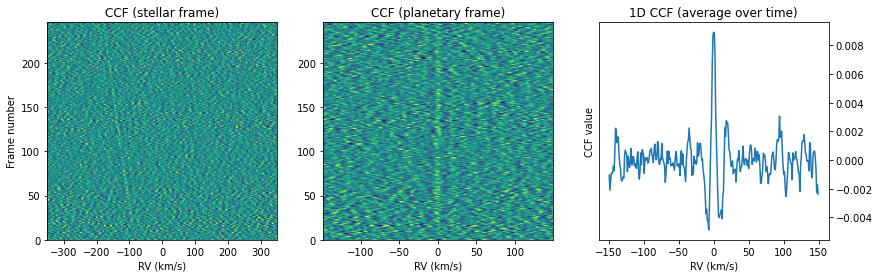

In [7]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

ccf.imshow(ax=ax[0])
ccf_shifted = ccf.to_planet_frame(planet)
ccf_shifted.imshow(ax=ax[1])
ax[2].plot(ccf_shifted.rv, np.median(ccf_shifted.flux, axis=0))

[ax[k].set_xlabel('RV (km/s)') for k in range(3)]
ax[0].set(ylabel='Frame number', title='CCF (stellar frame)')
ax[1].set(title='CCF (planetary frame)')
ax[2].yaxis.tick_right()
ax[2].set(ylabel='CCF value', title='1D CCF (average over time)')

plt.show()

Horizontal slice at Kp = 197.5 km/s
Vertical slice at Vrest = 0.0 km/s


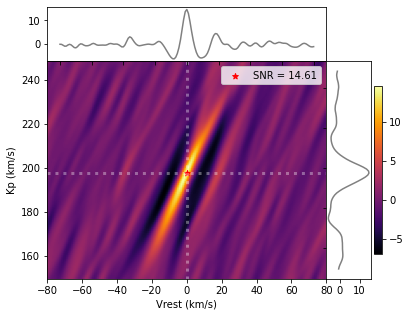

In [8]:
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure(snr_max=True)
plt.show()